# Теперь попробуем создать свою нейросеть и сравним с предобученной

### Ссылки
* [Датасет](https://www.kaggle.com/datasets/dmitriygolovachev/mushrooms-by-type/data)
* [Pickle file](https://drive.google.com/file/d/1YK_i8OmLBlAaiSnDa71yuYsitI-yXFue/view?usp=sharing)

## Импортируем необходимые модули модули

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Закачиваем датасет

In [21]:
import pathlib

# Перешёл в kaggle так как google colab отрубил мне GPU
dataset_dir = pathlib.Path("/kaggle/input/mushrooms-by-type").with_suffix('')

### Выводим кол-во. изображений в датасете

In [22]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 6714


## Создаем датасеты и кэшируем их

In [38]:
batch_size = 64
img_width = 227
img_height = 227

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6714 files belonging to 9 classes.
Using 5372 files for training.
Found 6714 files belonging to 9 classes.
Using 1342 files for validation.
Class names: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


# Создаем модель, компилируем её и выводим summary

In [39]:
num_classes = len(class_names)
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# регуляризация
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 227, 227, 3)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 227, 227, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_4 (RandomZoom)  (None, 227, 227, 3)       0         
                                                                 
 random_contrast_4 (RandomC  (None, 227, 227, 3)       0         
 ontrast)                                                        
                                                                 
 conv2d_18 (Conv2D)          (None, 227, 227, 16)     

In [41]:
# Добавим сallbacks
# Остановим обучение если метрика не улучшается
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10,
                                              restore_best_weights=True)

## Обучаем нейросеть

In [47]:
# train the model
epochs = 50 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs,
    callbacks=early_stop,
    )

Epoch 1/50
84/84 - 10s - loss: 2.0818 - accuracy: 0.2115 - val_loss: 2.0203 - val_accuracy: 0.2496 - 10s/epoch - 123ms/step
Epoch 2/50
84/84 - 7s - loss: 1.9859 - accuracy: 0.2577 - val_loss: 1.9525 - val_accuracy: 0.3003 - 7s/epoch - 86ms/step
Epoch 3/50
84/84 - 7s - loss: 1.8864 - accuracy: 0.3020 - val_loss: 1.8825 - val_accuracy: 0.2928 - 7s/epoch - 86ms/step
Epoch 4/50
84/84 - 7s - loss: 1.8111 - accuracy: 0.3398 - val_loss: 1.9278 - val_accuracy: 0.2750 - 7s/epoch - 87ms/step
Epoch 5/50
84/84 - 7s - loss: 1.7627 - accuracy: 0.3594 - val_loss: 1.7938 - val_accuracy: 0.3577 - 7s/epoch - 87ms/step
Epoch 6/50
84/84 - 7s - loss: 1.7201 - accuracy: 0.3676 - val_loss: 1.7473 - val_accuracy: 0.3718 - 7s/epoch - 87ms/step
Epoch 7/50
84/84 - 7s - loss: 1.6942 - accuracy: 0.3852 - val_loss: 1.7018 - val_accuracy: 0.3912 - 7s/epoch - 88ms/step
Epoch 8/50
84/84 - 7s - loss: 1.6680 - accuracy: 0.3891 - val_loss: 1.7056 - val_accuracy: 0.3689 - 7s/epoch - 87ms/step
Epoch 9/50
84/84 - 7s - loss:

## Делаем инференс на новых изображениях

1/1 [==============================] - 0s 21ms/step
На изображении скорее всего Boletus (94.33% вероятность)


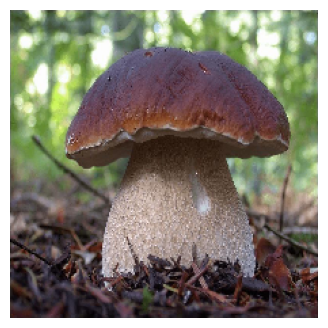

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# load image
sunflower_url = "https://drive.google.com/uc?export=download&id=1AN-szwwxYcQcxH79MRrQgaOGMN1mrG-4"
sunflower_path = tf.keras.utils.get_file('ukp', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself

fig = plt.gcf()
fig.set_size_inches(4, 4)
plt.imshow(img)
plt.axis('Off');

1/1 [==============================] - 0s 19ms/step
На изображении скорее всего Amanita (99.58% вероятность)


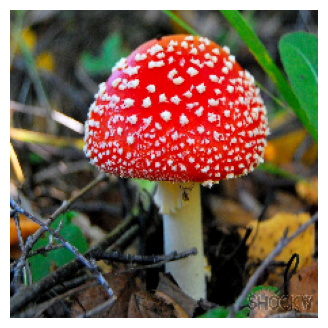

In [50]:
# load image
sunflower_url = "https://drive.google.com/uc?export=download&id=1noFbmX37EALd7xDHwRyhko-RYB2sMN7A"
sunflower_path = tf.keras.utils.get_file('amanita', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself

fig = plt.gcf()
fig.set_size_inches(4, 4)
plt.imshow(img)
plt.axis('Off');

## Оценим метрики модели

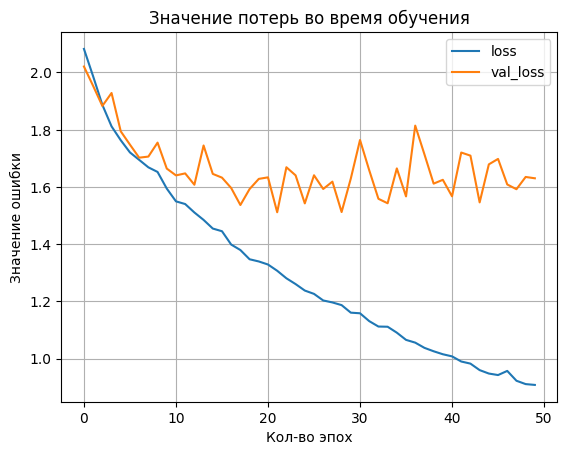

In [51]:
import pandas as pd

# Значение потерь во время обучения:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot(
    title='Значение потерь во время обучения',
    grid=True,
    xlabel='Кол-во эпох',
    ylabel='Значение ошибки'
    );

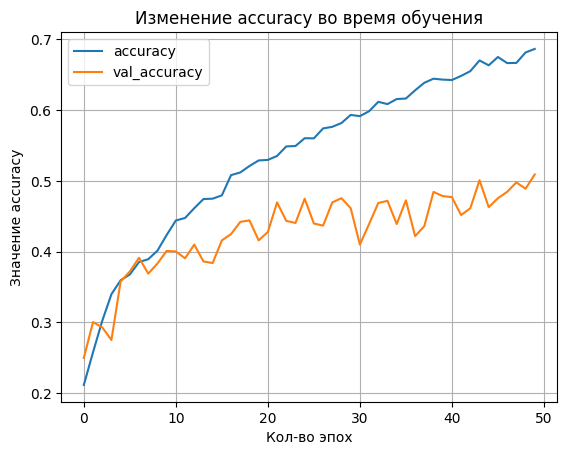

In [52]:
# Изменение accuracy во время обучения
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(
    title='Изменение accuracy во время обучения',
    grid=True,
    xlabel='Кол-во эпох',
    ylabel='Значение accuracy'
    );

# Выводы
* Модель выдаёт аccuracy около 0.5 - что мало для использования в приложении
* Предобученная модель работает гораздо лучше

## Экспорт файла модели

In [53]:
import pickle

pickle.dump(model, open("manual_build_classnn_by_type.pkl", "wb"))